#Import Library

In [1]:
!pip install xgboost lightgbm catboost imbalanced-learn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import pickle


#Input Data

In [3]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    df = pd.read_csv(fn)

pd.set_option('display.max_columns', None)
print("Data awal:")
display(df.head())

Saving df_arabica_clean (2).csv to df_arabica_clean (2).csv
Data awal:


,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,Producer,Number of Bags,Bag Weight,In-Country Partner,Harvest Year,Grading Date,Owner,Variety,Status,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Overall,Defects,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",Diego Samuel Bermudez,1,35 kg,Japan Coffee Exchange,2021 / 2022,"September 21st, 2022",Coffee Quality Union,Castillo,Completed,Double Anaerobic Washed,8.58,8.50,8.42,8.58,8.25,8.42,10.0,10.0,10.0,8.58,0.0,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,曾福森,1,80 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021 / 2022,"November 15th, 2022",Taiwan Coffee Laboratory 台灣咖啡研究室,Gesha,Completed,Washed / Wet,8.50,8.50,7.92,8.00,7.92,8.25,10.0,10.0,10.0,8.50,0.0,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,WU TAO CHI,19,25 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021 / 2022,"November 15th, 2022",Taiwan Coffee Laboratory 台灣咖啡研究室,Java,Completed,Semi Washed,8.33,8.42,8.08,8.17,7.92,8.17,10.0,10.0,10.0,8.33,0.0,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",Santa Maria de Dota,1,22 kg,Japan Coffee Exchange,2022,"September 21st, 2022",Coffee Quality Union,Gesha,Completed,Washed / Wet,8.08,8.17,8.17,8.25,8.17,8.08,10.0,10.0,10.0,8.25,0.0,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",Camilo Merizalde,2,24 kg,Japan Coffee Exchange,2022,"March 6th, 2023",Coffee Quality Union,Red Bourbon,Completed,"Honey,Mossto",8.33,8.33,8.08,8.25,7.92,7.92,10.0,10.0,10.0,8.25,0.0,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


#Prepocessing Data

##cek missing value

In [4]:
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Country of Origin,0
Farm Name,2
Lot Number,1
Mill,3
ICO Number,132
Company,0
Altitude,1
Region,2


In [5]:
def preprocess_batch(df):
    df = df.copy()

    # Mapping categorical
    processing_mapping = {
        "Double Anaerobic Washed": "Washed / Wet",
        "Semi Washed": "Washed / Wet",
        "Honey,Mossto": "Pulped natural / honey",
        "Double Carbonic Maceration / Natural": "Natural / Dry",
        "Wet Hulling": "Washed / Wet",
        "Anaerobico 1000h": "Washed / Wet",
        "SEMI-LAVADO": "Natural / Dry",
        np.nan: "Washed / Wet"
    }
    df['Processing Method'] = df['Processing Method'].replace(processing_mapping)

    variety_mapping = {

    # Gesha
    "Gesha": "Gesha",
    "Typica Gesha": "Gesha",
    "Sl34+Gesha": "Gesha",

    # Caturra
    "Caturra": "Caturra",
    "Red Bourbon,Caturra": "Caturra",
    "Castillo,Caturra,Bourbon": "Caturra",
    "Caturra-Catuai": "Caturra",
    "BOURBON, CATURRA Y CATIMOR": "Caturra",

    # Typica
    "Typica": "Typica",
    "Maragogype": "Typica",
    "Java": "Typica",
    "Gayo": "Typica",
    "Typica + SL34": "Typica",

    # Bourbon
    "Bourbon": "Bourbon",
    "Red Bourbon": "Bourbon",
    "Yellow Bourbon": "Bourbon",
    "Pacas": "Bourbon",
    "Mundo Novo": "Bourbon",
    "Bourbon Sidra": "Bourbon",
    "Catuai and Mundo Novo": "Bourbon",
    "Pacamara": "Bourbon",
    "SL14": "Bourbon",

    # Catuai
    "Catuai": "Catuai",
    "Yellow Catuai": "Catuai",
    "Catucai": "Catuai",
    "Catrenic": "Catuai",
    "MARSELLESA, CATUAI, CATURRA & MARSELLESA, ANACAFE 14, CATUAI": "Catuai",

    # Catimor / Sarchimor
    "Catimor": "Catimor",
    "Castillo": "Catimor",
    "Castillo Paraguaycito": "Catimor",
    "Parainema": "Catimor",
    "Sarchimor": "Catimor",
    "Lempira": "Catimor",
    "Jember,TIM-TIM,Ateng": "Catimor",
    "Castillo and Colombia blend": "Catimor",
    "Catimor,Catuai,Caturra,Bourbon": "Catimor",
    "Typica Bourbon Caturra Catimor": "Catimor",
    "Bourbon, Catimor, Caturra, Typica": "Catimor",
    "Caturra,Colombia,Castillo": "Catimor",

    # Ethiopian Landrace
    "Ethiopian Heirlooms": "Ethiopian Heirlooms",
    "Wolishalo,Kurume,Dega": "Ethiopian Heirlooms",
    "SL28": "Ethiopian Heirlooms",
    "SL28,SL34,Ruiru11": "Ethiopian Heirlooms",

    # SL34 standalone
    "SL34": "SL34",

    # Non varietal / noise
    "SHG": "Other",
    "unknown": "Other",
    "unknow": "Other",
     np.nan: "Other",
    "Santander": "Other"  # region, bukan varietas
    }
    df['Variety'] = df['Variety'].replace(variety_mapping)

    # Altitude fix
    df.loc[df['ID'] == 99, 'Altitude'] = 5273
    df.loc[df['ID'] == 105, 'Altitude'] = 1800
    df.loc[df['ID'] == 180, 'Altitude'] = 1400

    def clean_altitude(val):
        if isinstance(val, str):
            val = val.replace(" ", "")
            if '-' in val:
                try:
                    start,end = val.split('-')
                    return (int(start)+int(end))/2
                except: return np.nan
            else:
                try: return int(val)
                except: return np.nan
        return val
    df['Altitude'] = df['Altitude'].apply(clean_altitude)

    # Coffee Age
    df['Harvest Year'] = pd.to_datetime(df['Harvest Year'].astype(str).str.split('/').str[0].str.strip(), errors='coerce', format='%Y')
    df['Expiration'] = df['Expiration'].apply(lambda x: parser.parse(str(x)) if pd.notnull(x) else pd.NaT)
    df['Coffee Age'] = (df['Expiration'] - df['Harvest Year']).dt.days

    # Drop kolom tidak perlu
    drop_cols = ['Unnamed: 0', 'ID', 'Country of Origin','Lot Number', 'Mill', 'ICO Number',
                 'Company', 'Producer', 'Number of Bags', 'Bag Weight' , 'In-Country Partner',
                 'Grading Date', 'Owner','Status','Farm Name','Country','Region','Color',
                 'Harvest Year', 'Expiration', 'Certification Body', 'Certification Address', 'Certification Contact', 'Clean Cup', 'Sweetness', 'Defects']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

  #IMPUTASI
    # Fill NaN numerik dengan 0
    df = df.fillna(0)

    return df

df_clean = preprocess_batch(df)
print("Data setelah preprocessing:")
display(df_clean.head())

Data setelah preprocessing:


,Altitude,Variety,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects,Coffee Age
0,1815.0,Catimor,Washed / Wet,8.58,8.50,8.42,8.58,8.25,8.42,10.0,8.58,89.33,11.8,0,0,3,993
1,1200.0,Gesha,Washed / Wet,8.50,8.50,7.92,8.00,7.92,8.25,10.0,8.50,87.58,10.5,0,0,0,1048
2,1300.0,Typica,Washed / Wet,8.33,8.42,8.08,8.17,7.92,8.17,10.0,8.33,87.42,10.4,0,0,2,1048
3,1900.0,Gesha,Washed / Wet,8.08,8.17,8.17,8.25,8.17,8.08,10.0,8.25,87.17,11.8,0,0,0,628
4,1975.0,Bourbon,Pulped natural / honey,8.33,8.33,8.08,8.25,7.92,7.92,10.0,8.25,87.08,11.6,0,2,2,794


##distribusi data sebelum dilakukan preprocessing

In [7]:
import plotly.express as px

# Distribusi Metode Pengolahan
fig_processing = px.histogram(df, x='Processing Method', title='distribusi "Processing Method" sebelum dilakukan pemetaan')
fig_processing.show()
print("\nCounts of 'Processing Method' (cleaned data):")
print(df['Processing Method'].value_counts())

# Distribusi Varietas Kopi
fig_variety = px.histogram(df, x='Variety', title='distribusi "Variety" sebelum dilakukan pemetaan')
fig_variety.show()
print("\nCounts of 'Variety' (cleaned data):")
print(df['Variety'].value_counts())


Counts of 'Processing Method' (cleaned data):
Processing Method
Washed / Wet                            124
Natural / Dry                            46
Pulped natural / honey                   25
Double Anaerobic Washed                   1
Honey,Mossto                              1
Semi Washed                               1
Double Carbonic Maceration / Natural      1
Wet Hulling                               1
Anaerobico 1000h                          1
SEMI-LAVADO                               1
Name: count, dtype: int64



Counts of 'Variety' (cleaned data):
Variety
Gesha                                                           27
Caturra                                                         27
Typica                                                          23
Bourbon                                                         17
Catuai                                                          12
unknown                                                         12
Catimor                                                         11
Ethiopian Heirlooms                                              9
SL34                                                             8
Mundo Novo                                                       4
SL14                                                             3
Java                                                             3
Yellow Bourbon                                                   3
SHG                                                              3
SL28             

##distribusi data setelah dilakukan preprocessing

In [8]:
import plotly.express as px

# Distribusi Metode Pengolahan
fig_processing = px.histogram(df_clean, x='Processing Method', title='distribusi "Processing Method" setelah dilakukan pemetaan')
fig_processing.show()
print("\nCounts of 'Processing Method' (cleaned data):")
print(df_clean['Processing Method'].value_counts())

# Distribusi Varietas Kopi
fig_variety = px.histogram(df_clean, x='Variety', title='distribusi "Variety" setelah dilakukan pemetaan')
fig_variety.show()
print("\nCounts of 'Variety' (cleaned data):")
print(df_clean['Variety'].value_counts())


Counts of 'Processing Method' (cleaned data):
Processing Method
Washed / Wet              133
Natural / Dry              48
Pulped natural / honey     26
Name: count, dtype: int64



Counts of 'Variety' (cleaned data):
Variety
Bourbon                33
Caturra                31
Typica                 30
Gesha                  29
Catimor                24
Other                  23
Catuai                 16
Ethiopian Heirlooms    13
SL34                    8
Name: count, dtype: int64


#tentukan X dan Y

In [9]:
target = "Total Cup Points"
X = df_clean.drop(columns=[target])
y = df_clean[target]

#Normalisasi untuk data numerik dan Hot encoding untuk data kategorik

In [10]:
# Pilah kolom numerik dan kategorikal
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Buat preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
], remainder='drop')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit-transform untuk training, transform untuk testing
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Buat feature_names untuk dataframe hasil encoding
ohe = preprocessor.named_transformers_['cat']
if hasattr(ohe, 'get_feature_names_out'):
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
else:
    cat_names = categorical_features
feature_names = numeric_features + cat_names

# Konversi ke DataFrame agar bisa ditampilkan
df_encoded = pd.DataFrame(X_train_proc, columns=feature_names)

print("Dataset hasil One-Hot Encoding dan normalisasi (5 baris pertama):")
display(df_encoded.head())

Dataset hasil One-Hot Encoding dan normalisasi (5 baris pertama):


,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Overall,Moisture Percentage,Category One Defects,Quakers,Category Two Defects,Coffee Age,Variety_Bourbon,Variety_Catimor,Variety_Catuai,Variety_Caturra,Variety_Ethiopian Heirlooms,Variety_Gesha,Variety_Other,Variety_SL34,Variety_Typica,Processing Method_Natural / Dry,Processing Method_Pulped natural / honey,Processing Method_Washed / Wet
0,0.272249,-0.214719,0.273969,0.196420,0.488370,0.431660,0.077717,0.105127,-0.050824,0.250606,-0.212718,0.182329,-0.049896,-0.316851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.512684,-1.991482,-2.075262,-2.483507,-1.986434,-0.959927,-1.836211,0.105127,-1.939263,0.646300,-0.212718,-0.444427,0.665998,-0.509280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.905151,0.957944,0.273969,0.482278,-0.111582,-0.285218,0.690174,0.105127,0.749362,0.844147,-0.212718,-0.444427,-0.765790,0.637274,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.034153,0.069563,-0.010786,-0.125172,0.488370,0.431660,0.383946,0.105127,0.205236,-0.540782,-0.212718,-0.444427,-0.049896,-0.180548,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.054807,-1.707200,-2.075262,-1.911789,-2.623883,-2.393684,-2.180719,0.105127,-2.195322,0.844147,-0.212718,5.196377,3.171628,0.621239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##cek missing value setelah preprocessing

In [11]:
df_clean.isna().sum()

,0
Altitude,0
Variety,0
Processing Method,0
Aroma,0
Flavor,0
Aftertaste,0
Acidity,0
Body,0
Balance,0
Uniformity,0


#model

In [12]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
}

#model terbaik

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd # Ensure pandas is imported

results = {}
for name, model in models.items():
    # Fit the model first
    model.fit(X_train_proc, y_train)

    # Prediksi train & test
    y_pred_train = model.predict(X_train_proc)
    y_pred_test = model.predict(X_test_proc)

    # Simpan semua metrik
    results[name] = {
        "MAE_test": mean_absolute_error(y_test, y_pred_test),
        "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "R2_test": r2_score(y_test, y_pred_test),
        "MAE_train": mean_absolute_error(y_train, y_pred_train),
        "RMSE_train": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "R2_train": r2_score(y_train, y_pred_train)
    }

df_results = pd.DataFrame(results).T.sort_values(by="R2_test", ascending=False)
print("Perbandingan performa semua model:")
display(df_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 20
[LightGBM] [Info] Start training from score 83.767940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



,MAE_test,RMSE_test,R2_test,MAE_train,RMSE_train,R2_train
ExtraTrees,0.147390,0.281740,0.968207,1.851717e-14,2.949939e-14,1.000000
RandomForest,0.230838,0.359417,0.948260,7.912455e-02,1.240701e-01,0.995009
XGBoost,0.215913,0.376150,0.943330,1.104442e-03,1.605594e-03,0.999999
LightGBM,0.315195,0.489753,0.903930,1.265903e-01,2.233595e-01,0.983825


#feature enginering

Model terbaik berdasarkan R2_test: ExtraTrees


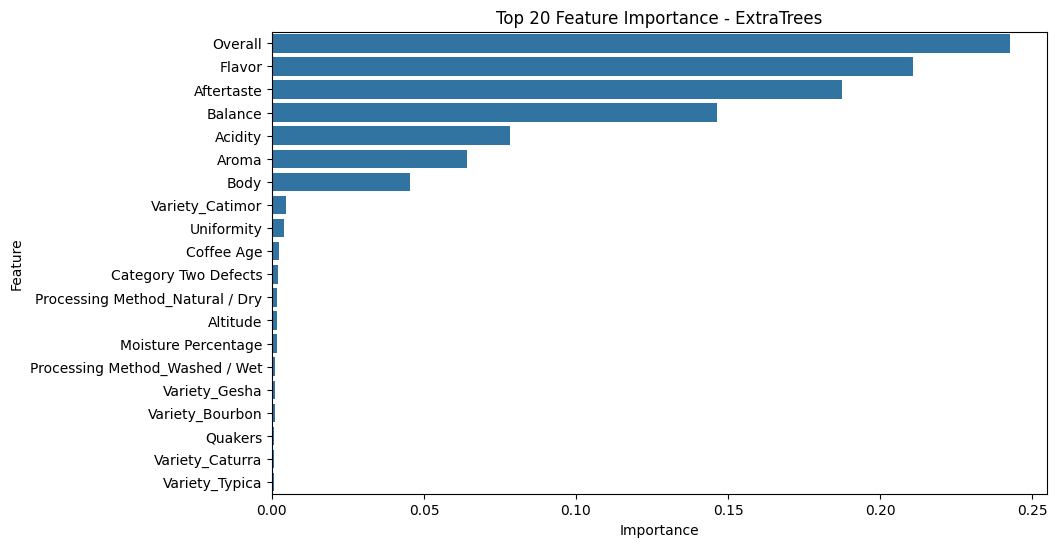

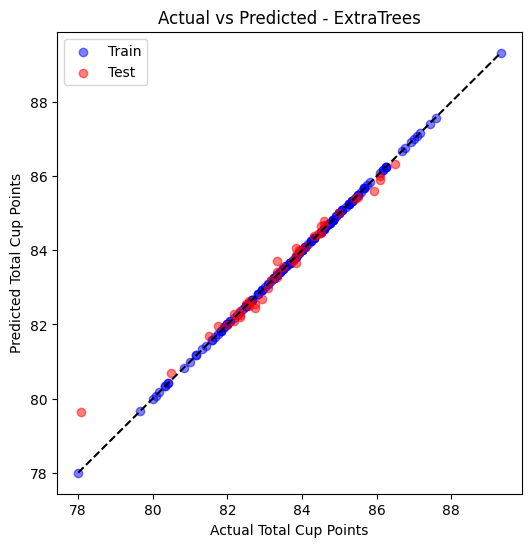

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns # Added this line

# -------------------------------
# 2. Tentukan model terbaik berdasarkan R2_test
# -------------------------------
best_model_name = df_results['R2_test'].idxmax()
best_model = models[best_model_name]
print(f"Model terbaik berdasarkan R2_test: {best_model_name}")

# -------------------------------
# 3. Feature importance (hanya untuk tree-based)
# -------------------------------
tree_models = ["RandomForest", "ExtraTrees", "XGBoost", "LightGBM", "CatBoost"]
if best_model_name in tree_models:
    if best_model_name == "CatBoost":
        importances = best_model.get_feature_importance()
    else:
        importances = best_model.feature_importances_

    feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feature_imp.values[:20], y=feature_imp.index[:20])
    plt.title(f"Top 20 Feature Importance - {best_model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
# -------------------------------
# 4. Train vs Test plot
# -------------------------------
# Calculate predictions for the best model
y_train_pred_best = best_model.predict(X_train_proc)
y_test_pred_best = best_model.predict(X_test_proc)

plt.figure(figsize=(6,6))
plt.scatter(y_train, y_train_pred_best, alpha=0.5, label="Train", color="blue")
plt.scatter(y_test, y_test_pred_best, alpha=0.5, label="Test", color="red")
plt.plot([min(y), max(y)], [min(y), max(y)], color="black", linestyle="--")  # y=x
plt.xlabel("Actual Total Cup Points")
plt.ylabel("Predicted Total Cup Points")
plt.title(f"Actual vs Predicted - {best_model_name}")
plt.legend()
plt.show()

Best model: ExtraTrees
Feature importance method: feature_importances_


,0
Overall,0.242738
Flavor,0.210709
Aftertaste,0.187414
Balance,0.146256
Acidity,0.078257
Aroma,0.064071
Body,0.045549
Variety_Catimor,0.004613
Uniformity,0.003951
Coffee Age,0.002185


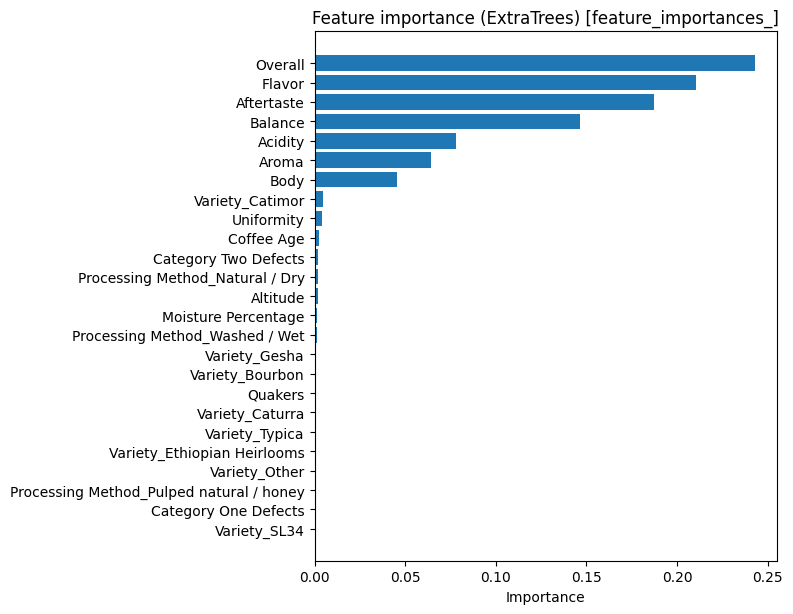

In [15]:
from sklearn.inspection import permutation_importance
best_name = df_results.index[0]
best_model = models[best_model_name] # Retrieve the best model (unfitted) from the dictionary
best_model.fit(X_train_proc, y_train) # Fit the best model before using it
print("Best model:", best_name)

# Feature names exist from earlier
fnames = feature_names # Using feature_names from UZYrAL3NmZnP

# Try model.feature_importances_ first
if hasattr(best_model, "feature_importances_"):
    fi = pd.Series(best_model.feature_importances_, index=fnames).sort_values(ascending=False)
    method = "feature_importances_"
elif hasattr(best_model, "coef_"): # Handle linear models that have coefficients
    fi = pd.Series(np.abs(best_model.coef_), index=fnames).sort_values(ascending=False)
    method = "coefficients_abs"
else:
    # permutation importance (works for any model)
    print("Computing permutation importance (fallback)...")
    perm = permutation_importance(best_model, X_test_proc, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    fi = pd.Series(perm.importances_mean, index=fnames).sort_values(ascending=False)
    method = "permutation"

print("Feature importance method:", method)
display(fi.head(40))

# Plot horizontal bar (top 25)
import matplotlib.pyplot as plt
topn = min(25, fi.shape[0])
fi_top = fi.head(topn).sort_values()
plt.figure(figsize=(8, max(3, 0.25*topn)))
plt.barh(fi_top.index, fi_top.values)
plt.title(f"Feature importance ({best_name}) [{method}]")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#Simpan Model

In [26]:
import joblib

# -------------------------------
# Simpan preprocessor
# -------------------------------
joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessor disimpan sebagai preprocessor.pkl")

# -------------------------------
# Simpan model terbaik
# -------------------------------
joblib.dump(best_model, "best_model.pkl")
print(f"Model terbaik ({best_model_name}) disimpan sebagai best_model.pkl")


Preprocessor disimpan sebagai preprocessor.pkl
Model terbaik (ExtraTrees) disimpan sebagai best_model.pkl


#Statistik Deskriptif

In [16]:
print("Descriptive Statistics for Numerical Columns:")
display(df_clean.describe())

print("\nDescriptive Statistics for Categorical Columns:")
display(df_clean.describe(include='object'))

Descriptive Statistics for Numerical Columns:


,Altitude,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Category Two Defects,Coffee Age
count,207.000000,207.000000,207.000000,207.000000,207.00000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,1314.099034,7.721063,7.744734,7.599758,7.69029,7.640918,7.644058,9.990338,7.676812,83.706570,10.735266,0.135266,0.690821,2.251208,893.565217
std,720.564046,0.287626,0.279613,0.275911,0.25951,0.233499,0.256299,0.103306,0.306359,1.730417,1.247468,0.592070,1.686918,2.950183,234.373891
min,139.000000,6.500000,6.750000,6.670000,6.83000,6.830000,6.670000,8.670000,6.670000,78.000000,0.000000,0.000000,0.000000,0.000000,431.000000
25%,1020.000000,7.580000,7.580000,7.420000,7.50000,7.500000,7.500000,10.000000,7.500000,82.580000,10.100000,0.000000,0.000000,0.000000,753.000000
50%,1340.000000,7.670000,7.750000,7.580000,7.67000,7.670000,7.670000,10.000000,7.670000,83.750000,10.800000,0.000000,0.000000,1.000000,880.000000
75%,1600.000000,7.920000,7.920000,7.750000,7.87500,7.750000,7.790000,10.000000,7.920000,84.830000,11.500000,0.000000,1.000000,3.000000,1048.000000
max,5400.000000,8.580000,8.500000,8.420000,8.58000,8.250000,8.420000,10.000000,8.580000,89.330000,13.500000,5.000000,12.000000,16.000000,2487.000000



Descriptive Statistics for Categorical Columns:


,Variety,Processing Method
count,207,207
unique,9,3
top,Bourbon,Washed / Wet
freq,33,133


#Korelasi

Correlation Matrix for Numerical Columns (Heatmap):


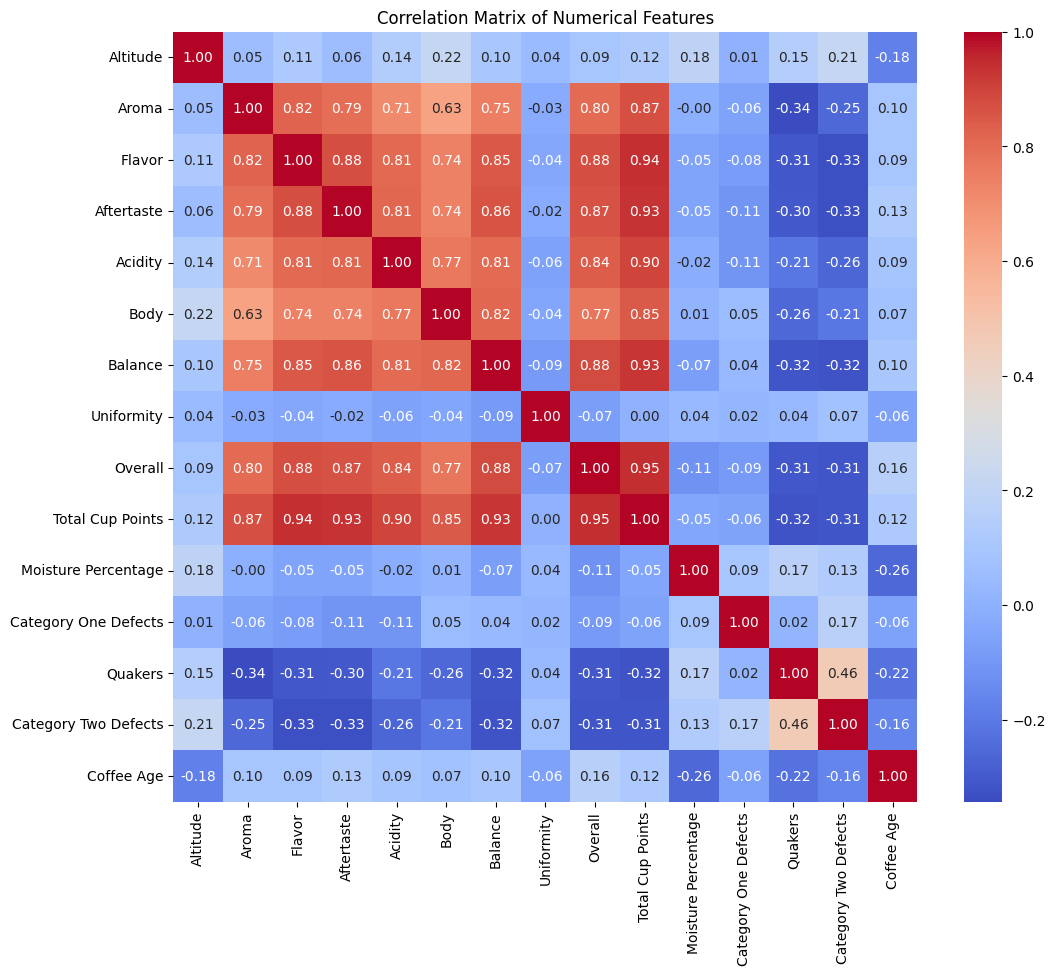

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Correlation Matrix for Numerical Columns (Heatmap):")
corr_matrix = df_clean.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()